In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import re  
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# import string
import warnings
# ! pip install wordcloud
#from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder,LabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score, recall_score,roc_curve, roc_auc_score, auc

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout,GRU
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler


In [3]:
#load test and train data
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [4]:
train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [5]:
test.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [6]:
#load validation data
test_val= pd.read_csv("test_data_hidden.csv")
test_val.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [7]:
train.duplicated().sum()

58

In [8]:
train = train.drop_duplicates().reset_index(drop=True)

In [9]:
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,3942,3942,3942,3942,3942,3942,3932,3942
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,Got this for my Daughter-in-Law and she loves ...,Great tablet,Positive
freq,676,3942,628,2562,98,4,99,3694


In [10]:
train.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

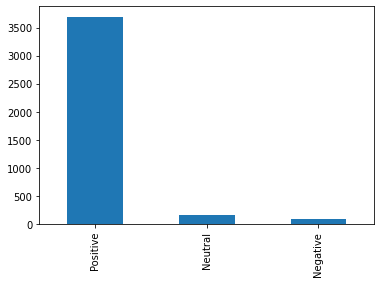

In [11]:
train['sentiment'].value_counts().plot(kind='bar')

In [12]:
#Reviews containing Positive Sentiments
train[train.sentiment=='Positive'][['reviews.text','reviews.title']].head()

,reviews.text,reviews.title
0,Purchased on Black FridayPros - Great Price (e...,Powerful tablet
1,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME
3,"very good product. Exactly what I wanted, and ...",Greattttttt
4,This is the 3rd one I've purchased. I've bough...,Very durable!
5,This is a great product. Light weight. I wish ...,You will love it


In [13]:
#Reviews containing Negative Sentiments
train[train.sentiment=='Negative'][['reviews.text','reviews.title']].head()

,reviews.text,reviews.title
9,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned"
97,"Worthless, except as a regular echo and a poor...",Useless screen so why pay for it?
104,Too bad Amazon turned this tablet into a big a...,Amazon Fire 7 Tablet
121,I bought this Kindle for my 7 year old grand-d...,Kid's Kindle
150,I am reading positive reviews and wish I could...,Have never purchased a more frustrating Device


In [14]:
#Reviews containing Neutral Sentiments
train[train.sentiment=='Neutral'][['reviews.text','reviews.title']].head()

,reviews.text,reviews.title
2,Just an average Alexa option. Does show a few ...,Average
6,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet
17,"Not as good as before the old kindle, just sea...",Not as good as before
59,There is nothing spectacular about this item b...,"Does what it says, missing one key feature"
95,It's unfair for me to rate this product cause ...,Haven't set it up yet


In [15]:
#products with their value counts
pd.DataFrame(train.name.value_counts())

,name
"Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",676
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",628
Amazon - Echo Plus w/ Built-In Hub - Silver,483
"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",446
"Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue",340
"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",294
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,177
"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",175
"Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers",122
"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum",82


In [16]:
pd.DataFrame(train.categories.value_counts())

,categories
"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets",628
"Computers,Amazon Echo,Virtual Assistant Speakers,Audio & Video Components,Electronics Features,Computer Accessories,Home & Tools,See more Amazon Echo Show Smart Assistant - White,Smart Home Automation,Electronics,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Consumer Electronics,Wireless Speakers,Home Improvement,Amazon Home,Amazon,Computer Speakers,Voice-Enabled Smart Assistants",514
"Amazon Echo,Smart Home,Networking,Home & Tools,Home Improvement,Smart Home Automation,Voice Assistants,Amazon Home,Amazon,Smart Hub & Kits,Digital Device 3",483
"Computers,Fire Tablets,Electronics Features,Computer Accessories,Tablets,Top Rated,Amazon Tablets,Electronics,Kids' Tablets,iPad & Tablets,Cases & Bags,Electronics, Tech Toys, Movies, Music,Computers & Tablets",446
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets",340
"Fire Tablets,Computers/Tablets & Networking,Tablets,All Tablets,Amazon Tablets,Frys,Computers & Tablets,Tablets & eBook Readers",294
"Fire Tablets,Tablets,All Tablets,Amazon Tablets,Computers & Tablets",231
"Amazon Echo,Home Theater & Audio,MP3 MP4 Player Accessories,Electronics,Portable Audio,Compact Radios Stereos,Smart Hubs & Wireless Routers,Featured Brands,Smart Home & Connected Living,Home Security,Kindle Store,Electronic Components,Home Automation,Mobile Bluetooth Speakers,Home, Garage & Office,Amazon Tap,Home,Mobile Speakers,TVs & Electronics,Portable Bluetooth Speakers,Bluetooth & Wireless Speakers,Electronics Features,Frys,Speakers,Mobile,Digital Device 3,Smart Home,Home Improvement,Electronics, Tech Toys, Movies, Music,Smart Home & Home Automation Devices,Smart Hubs,MP3 Player Accessories,Home Safety & Security,Voice Assistants,Amazon Home,Alarms & Sensors,Portable Audio & Electronics,Amazon Devices,Audio,Bluetooth Speakers,MP3 Accessories,All Bluetooth & Wireless Speakers",177
"Amazon Echo,Virtual Assistant Speakers,Electronics Features,Home & Tools,Smart Home Automation,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Wireless Speakers,Smart Home,Home Improvement,Voice Assistants,Amazon Home,Amazon",162
"Office,eBook Readers,Electronics Features,Walmart for Business,Tablets,Electronics,Amazon Ereaders,Office Electronics,iPad & Tablets,Kindle E-readers,All Tablets,Amazon Book Reader,Computers & Tablets",122


In [17]:
pd.DataFrame(train.brand.value_counts())

,brand
Amazon,3942


In [ ]:
# now we have see how positive,negative and neutral review looks like and also the checked the counts and can see its very imbalance having more positive reviews

In [ ]:
# clean the data

In [ ]:
#as all the producst belong to amazon brand dropping the column from all the data sets

In [18]:
del test['brand']
del train['brand']
del test_val['brand']

In [19]:
train['reviews.date'] = train['reviews.date'].str.split('T').str[0]
test_val['reviews.date'] = test_val['reviews.date'].str.split('T').str[0]
test['reviews.date'] = test['reviews.date'].str.split('T').str[0]

train['reviews_day'] = pd.to_datetime(train['reviews.date'], format='%Y-%m-%d').dt.day
train['reviews_month'] = pd.to_datetime(train['reviews.date'], format='%Y-%m-%d').dt.month
train['reviews_year'] = pd.to_datetime(train['reviews.date'], format='%Y-%m-%d').dt.year

test_val['reviews_day'] = pd.to_datetime(test_val['reviews.date'], format='%Y-%m-%d').dt.day
test_val['reviews_month'] = pd.to_datetime(test_val['reviews.date'], format='%Y-%m-%d').dt.month
test_val['reviews_year'] = pd.to_datetime(test_val['reviews.date'], format='%Y-%m-%d').dt.year

test['reviews_day'] = pd.to_datetime(test['reviews.date'], format='%Y-%m-%d').dt.day
test['reviews_month'] = pd.to_datetime(test['reviews.date'], format='%Y-%m-%d').dt.month
test['reviews_year'] = pd.to_datetime(test['reviews.date'], format='%Y-%m-%d').dt.year

del train['reviews.date']
del test['reviews.date']
del test_val['reviews.date']

train.head()

,name,categories,primaryCategories,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,26,12,2016
1,Amazon - Echo Plus w/ Built-In Hub - Silver,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,17,1,2018
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",Just an average Alexa option. Does show a few ...,Average,Neutral,20,12,2017
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...","eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics","very good product. Exactly what I wanted, and ...",Greattttttt,Positive,4,8,2017
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...","Computers/Tablets & Networking,Tablets & eBook...",Electronics,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,23,1,2017


In [20]:
name = list(set(list(train['name'])+list(test_val['name'])))
categories = list( set( list( train['categories']) + list(test_val['categories'])))
primaryCategories = list(train['primaryCategories'].unique())

le_name = LabelEncoder()
le_cat = LabelEncoder()
le_pri = LabelEncoder()
le_name.fit(name)
le_cat.fit(categories)
le_pri.fit(primaryCategories)

train['name'] = le_name.transform(train.name)
train['categories'] = le_cat.transform(train.categories)
train['primaryCategories'] = le_pri.transform(train.primaryCategories)
test_val['name'] = le_name.transform(test_val.name)
test_val['categories'] = le_cat.transform(test_val.categories)
test_val['primaryCategories'] = le_pri.transform(test_val.primaryCategories)
test['name'] = le_name.transform(test.name)
test['categories'] = le_cat.transform(test.categories)
test['primaryCategories'] = le_pri.transform(test.primaryCategories)

In [21]:
train['reviews.title'].fillna(value=' ',inplace=True)
test_val['reviews.title'].fillna(value=' ',inplace=True)
test['reviews.title'].fillna(value=' ',inplace=True)

In [22]:
import nltk
nltk.download('wordnet')

tok = WordPunctTokenizer()
ps = PorterStemmer()
wnl = WordNetLemmatizer()
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
def data_cleaner(text):
    text = text.replace(r"Äú",'')
    text = text.replace(r'Äù','')
    text = text.replace(r'‚Äô','\'')
    text = text.lower()
    text = text.replace(r'‚Äô','\'')
    text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
    text = re.sub("[^a-zA-Z0-9\"]", " ", text)
    word_tok=[x for x in tok.tokenize(text) if len(x) > 3]
#     word_stem = [ps.stem(i) for i in word_tok]
#     return (" ".join(word_stem).strip())  
    word_lem = [wnl.lemmatize(i) for i in word_tok]
    return (" ".join(word_lem).strip()) 
for i in (train,test_val,test):
    i['reviews.text']=i['reviews.text'].apply(data_cleaner)
    i['reviews.title']=i['reviews.title'].apply(data_cleaner)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


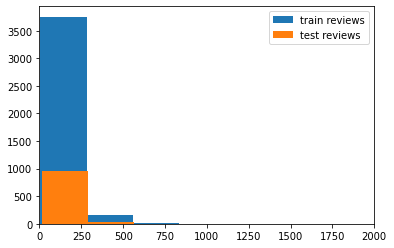

In [23]:
# visualising both test and train class
train_len=train["reviews.text"].str.len()
test_len=test["reviews.text"].str.len()
plt.hist(train_len,bins=20,label="train reviews")
plt.hist(test_len,bins=20,label="test reviews")
plt.legend()
plt.xlim(0,2000)
plt.show()

In [ ]:
#ecoding the target variable

In [24]:
le_senti = LabelEncoder()
train['sentiment'] = le_senti.fit_transform(train['sentiment'])
test_val['sentiment'] = le_senti.fit_transform(test_val['sentiment'])
train

,name,categories,primaryCategories,reviews.text,reviews.title,sentiment,reviews_day,reviews_month,reviews_year
0,2,10,0,purchased black fridaypros great price even sa...,powerful tablet,2,26,12,2016
1,5,1,1,purchased amazon echo plus dot plus four fire ...,amazon echo plus awesome,2,17,1,2018
2,9,2,1,just average alexa option doe show thing scree...,average,1,20,12,2017
3,14,22,3,very good product exactly what wanted very goo...,greattttttt,2,4,8,2017
4,13,9,0,this purchased bought niece other case compare...,very durable,2,23,1,2017
...,...,...,...,...,...,...,...,...,...
3937,5,1,1,family play with boring after newness wear,,2,8,12,2017
3938,11,7,0,love kindle great product reduces strain enjoy...,great product,2,31,3,2017
3939,12,0,0,looking blutooth speaker with phone want worry...,great dumb speaker,2,19,1,2017
3940,13,9,0,this second amazon fire tablet have purchased ...,great inch tablet great price,2,27,5,2016


In [ ]:
#performing tfidf vectorization on the review text and title text

In [25]:
tvec1 = TfidfVectorizer()
tvec2 = TfidfVectorizer()
tvec3 = TfidfVectorizer()


In [26]:
train1 = train.reset_index()
combi1 = train1.append(test_val,ignore_index=True,sort=False)
tvec1.fit(combi1['reviews.text'])
tvec_text1 = pd.DataFrame(tvec1.transform(train1['reviews.text']).toarray())
tvec_text2 = pd.DataFrame(tvec1.transform(test_val['reviews.text']).toarray())
tvec2.fit(combi1['reviews.title'])
tvec_title1 = pd.DataFrame(tvec2.transform(train1['reviews.title']).toarray())
tvec_title2 = pd.DataFrame(tvec2.transform(test_val['reviews.title']).toarray())
Train1 = pd.concat([train1.drop(['reviews.text','reviews.title','sentiment','index'],axis=1),tvec_text1, tvec_title1],axis=1)
Test_Val1 = pd.concat([test_val.drop(['reviews.text','reviews.title','sentiment'],axis=1),tvec_text2, tvec_title2],axis=1)
x_train1=Train1.values
y_train1=train['sentiment'].values
x_val1=Test_Val1.values
y_val1 = test_val['sentiment'].values

In [27]:
#applying stopwords removal stemming and tockenization
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text

punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]
tvec3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
reviews=tvec3.fit_transform(combi1['reviews.text'])
words = tvec3.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
#applying multinomail naive bayes
nb = MultinomialNB()
nb.fit(Train1.values,train1['sentiment'])
y_pred = nb.predict(Test_Val1.values)
y_val = test_val['sentiment']
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print(accuracy_score(y_val, y_pred)*100)

[[  0   0  24]
 [  0   0  39]
 [  0   0 937]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.88      0.94      0.91      1000

93.7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# all predicted positive as the data set is imbalanced with the most of the positive comments

In [ ]:
# balance the data

In [ ]:
train.sentiment.value_counts()

2    3694
1     158
0      90
Name: sentiment, dtype: int64

In [ ]:
count_2, count_1, count_0 =train.sentiment.value_counts()
class_2 = train[train.sentiment==2]
class_1 = train[train.sentiment==1]
class_0 = train[train.sentiment==0]

In [ ]:
#under samplimg
class_2_under = class_2.sample(count_1)
train_under= pd.concat([class_2_under,class_1,class_0],axis=0)
print(train_under.shape)
print(train_under.sentiment.value_counts())

(406, 9)
2    158
1    158
0     90
Name: sentiment, dtype: int64


In [ ]:
#over sampling
class_0_over = class_0.sample(count_2,replace=True)
class_1_over = class_1.sample(count_2,replace=True)
train_over = pd.concat([class_2,class_0_over,class_1_over],axis=0)
print(train_over.shape)
print(train_over.sentiment.value_counts())

(11082, 9)
2    3694
1    3694
0    3694
Name: sentiment, dtype: int64


In [ ]:
#tfidf and logistic for under sampling

In [ ]:
lr= LogisticRegression(C=30, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', n_jobs=6, random_state=40, 
                         verbose=1, max_iter=1000)

In [ ]:
train = train_under.reset_index(drop=True) 
combi = train.append(test_val , ignore_index=True)
print(combi.shape)

tvec1.fit(combi['reviews.text'])
tvec_text1 = pd.DataFrame(tvec1.transform(train['reviews.text']).toarray())
tvec_text2 = pd.DataFrame(tvec1.transform(test_val['reviews.text']).toarray())

tvec2.fit(combi['reviews.title'])
tvec_title1 = pd.DataFrame(tvec2.transform(train['reviews.title']).toarray())
tvec_title2 = pd.DataFrame(tvec2.transform(test_val['reviews.title']).toarray())

Train = pd.concat([train.drop(['reviews.text','reviews.title','sentiment'],axis=1),tvec_text1, tvec_title1],axis=1)
Test_Val = pd.concat([test_val.drop(['reviews.text','reviews.title','sentiment'],axis=1),tvec_text2, tvec_title2],axis=1)
x_train=Train.values
y_train=train['sentiment']
x_val=Test_Val.values
y_val = test_val['sentiment']

(1406, 9)


In [ ]:
#logistic

In [ ]:
lr.fit(x_train,y_train)
y_pred = lr.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print('accuracy : ',accuracy_score(y_val, y_pred)*100)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


max_iter reached after 22 seconds
[[ 10   5   9]
 [ 12   7  20]
 [265 195 477]]
              precision    recall  f1-score   support

           0       0.03      0.42      0.06        24
           1       0.03      0.18      0.06        39
           2       0.94      0.51      0.66       937

    accuracy                           0.49      1000
   macro avg       0.34      0.37      0.26      1000
weighted avg       0.89      0.49      0.62      1000

accuracy :  49.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   22.7s finished


0.5238772595036776


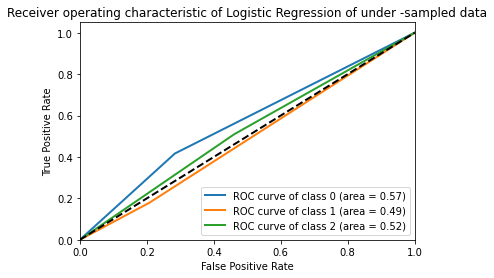

In [ ]:
lb = LabelBinarizer()
lb.fit(y_val)
y_val1 = lb.transform(y_val)
y_pred1 = lb.transform(y_pred)
print(roc_auc_score(y_val1, y_pred1, average='weighted'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw=2
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Logistic Regression of under -sampled data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#tfidf and logistic for over sampling

In [ ]:
train = train_over.reset_index(drop=True) 

tvec1.fit(train['reviews.text'])
tvec_text1 = pd.DataFrame(tvec1.transform(train['reviews.text']).toarray())
tvec_text2 = pd.DataFrame(tvec1.transform(test_val['reviews.text']).toarray())

tvec2.fit(train['reviews.title'])
tvec_title1 = pd.DataFrame(tvec2.transform(train['reviews.title']).toarray())
tvec_title2 = pd.DataFrame(tvec2.transform(test_val['reviews.title']).toarray())

Train = pd.concat([train.drop(['reviews.text','reviews.title','sentiment'],axis=1),tvec_text1, tvec_title1],axis=1)
Test_Val = pd.concat([test_val.drop(['reviews.text','reviews.title','sentiment'],axis=1),tvec_text2, tvec_title2],axis=1)

Train.to_csv('Train.csv',encoding='utf-8')
Test_Val.to_csv('Test_Val.csv',encoding='utf-8')

x_train=Train.values
y_train=train['sentiment'].values
x_val=Test_Val.values
y_val = test_val['sentiment'].values

In [ ]:
lr.fit(x_train,y_train)
y_pred = lr.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print('accuracy : ',accuracy_score(y_val, y_pred)*100)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


max_iter reached after 911 seconds
[[ 14   2   8]
 [ 11   8  20]
 [203 155 579]]
              precision    recall  f1-score   support

           0       0.06      0.58      0.11        24
           1       0.05      0.21      0.08        39
           2       0.95      0.62      0.75       937

    accuracy                           0.60      1000
   macro avg       0.35      0.47      0.31      1000
weighted avg       0.90      0.60      0.71      1000

accuracy :  60.099999999999994


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed: 15.2min finished


In [ ]:
#Logistic Regression on over-sampled data is perfrorming better than under-sampled data

0.5864608862201448


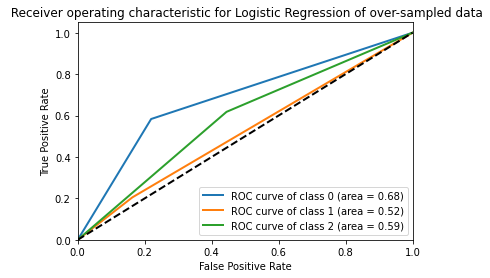

In [ ]:
lb = LabelBinarizer()
lb.fit(y_val)
y_val1 = lb.transform(y_val)
y_pred1 = lb.transform(y_pred)
print(roc_auc_score(y_val1, y_pred1, average='weighted'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw=2
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic for Logistic Regression of over-sampled data')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#multinomail naive bayes
nb = MultinomialNB()
nb.fit(x_train,y_train)
y_pred = nb.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print(accuracy_score(y_val, y_pred)*100)
print(nb.score(x_train,y_train))
print(nb.score(x_val,y_val))

[[ 12   4   8]
 [  4  14  21]
 [ 10  90 837]]
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        24
           1       0.13      0.36      0.19        39
           2       0.97      0.89      0.93       937

    accuracy                           0.86      1000
   macro avg       0.52      0.58      0.53      1000
weighted avg       0.92      0.86      0.89      1000

86.3
0.956506045840101
0.863


0.713761750556372


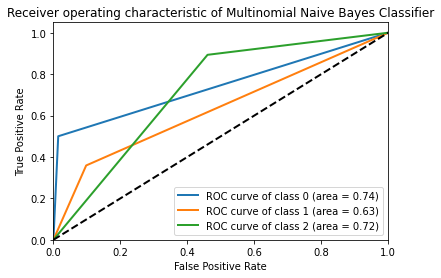

In [ ]:
lb = LabelBinarizer()
lb.fit(y_val)
y_val1 = lb.transform(y_val)
y_pred1 = lb.transform(y_pred)
print(roc_auc_score(y_val1, y_pred1, average='weighted'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw=2
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Multinomial Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Random forest

rf= RandomForestClassifier(n_estimators=400,random_state=10).fit(x_train,y_train)
y_pred=rf.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print('accuracy : ',accuracy_score(y_val, y_pred)*100)
print(rf.score(x_train,y_train))
print(rf.score(x_val,y_val))

[[  7   0  17]
 [  0  10  29]
 [  0   0 937]]
              precision    recall  f1-score   support

           0       1.00      0.29      0.45        24
           1       1.00      0.26      0.41        39
           2       0.95      1.00      0.98       937

    accuracy                           0.95      1000
   macro avg       0.98      0.52      0.61      1000
weighted avg       0.96      0.95      0.94      1000

accuracy :  95.39999999999999
1.0
0.954


0.6349206349206349


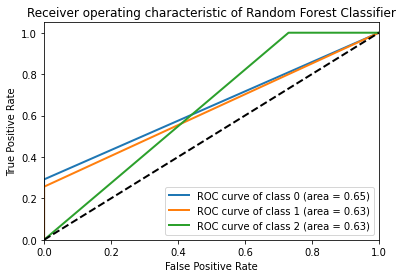

In [ ]:
lb = LabelBinarizer()
lb.fit(y_val)
y_val1 = lb.transform(y_val)
y_pred1 = lb.transform(y_pred)
print(roc_auc_score(y_val1, y_pred1, average='weighted'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw=2
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#XGboost

xgb= XGBClassifier(n_estimators=1000,max_depth=6).fit(x_train,y_train)
y_pred=xgb.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print("accuracy : ",accuracy_score(y_val, y_pred)*100)

[[ 11   1  12]
 [  2  12  25]
 [  3   6 928]]
              precision    recall  f1-score   support

           0       0.69      0.46      0.55        24
           1       0.63      0.31      0.41        39
           2       0.96      0.99      0.98       937

    accuracy                           0.95      1000
   macro avg       0.76      0.59      0.65      1000
weighted avg       0.94      0.95      0.94      1000

accuracy :  95.1


0.7001456913972267


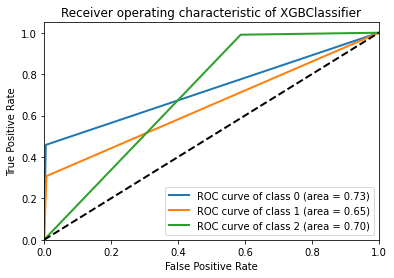

In [ ]:
lb = LabelBinarizer()
lb.fit(y_val)
y_val1 = lb.transform(y_val)
y_pred1 = lb.transform(y_pred)
print(roc_auc_score(y_val1, y_pred1, average='weighted'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw=2
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of XGBClassifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#XGBoost is performing better in predicting all the classes

In [ ]:
#multiclass SVM
svc = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=0).fit(x_train, y_train) 
y_pred=svc.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print("accuracy : ",accuracy_score(y_val, y_pred)*100)

[[ 14   2   8]
 [  5  15  19]
 [ 18  46 873]]
              precision    recall  f1-score   support

           0       0.38      0.58      0.46        24
           1       0.24      0.38      0.29        39
           2       0.97      0.93      0.95       937

    accuracy                           0.90      1000
   macro avg       0.53      0.63      0.57      1000
weighted avg       0.93      0.90      0.91      1000

accuracy :  90.2


0.7489575133971978


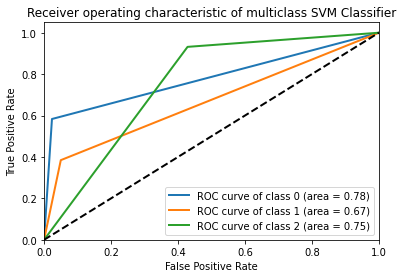

In [ ]:
lb = LabelBinarizer()
lb.fit(y_val)
y_val1 = lb.transform(y_val)
y_pred1 = lb.transform(y_pred)
print(roc_auc_score(y_val1, y_pred1, average='weighted'))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw=2
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multiclass SVM Classifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Deepl learning neural networks

In [ ]:
y_train2 = label_binarize(y_train1, classes=[0, 1, 2])
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train1),
                                                 y_train1)

In [ ]:

classifier = Sequential()
classifier.add(Dense(units=100,kernel_initializer='he_uniform',activation='relu',input_dim=x_train1.shape[1]))
classifier.add(Dense(units=80,kernel_initializer='he_uniform',activation='relu'))
classifier.add(Dense(units=80,kernel_initializer='he_uniform',activation='relu'))
classifier.add(Dense(units=3,kernel_initializer='normal',activation='softmax'))
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier.fit(x_train1,y_train2,batch_size=256,epochs=100,verbose=0)
y_pred = classifier.predict(x_val1, batch_size=256)
y_pred_bool = np.argmax(y_pred, axis=1)


In [ ]:
print(classification_report(y_val, y_pred_bool))

              precision    recall  f1-score   support

           0       0.90      0.38      0.53        24
           1       0.41      0.28      0.33        39
           2       0.96      0.99      0.98       937

    accuracy                           0.95      1000
   macro avg       0.76      0.55      0.61      1000
weighted avg       0.94      0.95      0.94      1000



In [ ]:

y_train3 = label_binarize(y_train, classes=[0, 1, 2])

In [ ]:
#for over-sampled data
classifier = Sequential()
classifier.add(Dense(units=50,activation='relu',input_dim=x_train.shape[1]))
classifier.add(Dense(units=40,activation='relu'))
classifier.add(Dense(units=150,activation='relu'))
classifier.add(Dense(units=3,kernel_initializer='normal',activation='softmax'))
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier.fit(x_train,y_train3,batch_size=256,epochs=10,verbose=0)
y_pred = classifier.predict(x_val, batch_size=256)
y_pred_bool = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_val, y_pred_bool))
print(classification_report(y_val, y_pred_bool))

[[ 13   2   9]
 [  2  11  26]
 [ 10  33 894]]
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        24
           1       0.24      0.28      0.26        39
           2       0.96      0.95      0.96       937

    accuracy                           0.92      1000
   macro avg       0.57      0.59      0.58      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:
#XGboost + oversampled_multinomial_NB

In [ ]:

from sklearn.ensemble import VotingClassifier
model1 = MultinomialNB()
model2 =  XGBClassifier(n_estimators=1000,max_depth=6)
model = VotingClassifier(estimators=[('lr', model1), ('dt', model2)], voting='hard')
model.fit(x_train,y_train)
y_pred = model.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print("accuracy : ",accuracy_score(y_val, y_pred)*100)

[[ 13   3   8]
 [  5  16  18]
 [ 12  93 832]]
              precision    recall  f1-score   support

           0       0.43      0.54      0.48        24
           1       0.14      0.41      0.21        39
           2       0.97      0.89      0.93       937

    accuracy                           0.86      1000
   macro avg       0.52      0.61      0.54      1000
weighted avg       0.92      0.86      0.89      1000

accuracy :  86.1


In [ ]:
#sentiment score

In [ ]:
from textblob import TextBlob
def senti(x):
    return TextBlob(x).sentiment 
def polarity(x):
    return TextBlob(x).polarity+1
 
train['senti_score'] = train['reviews.text'].apply(senti)
test_val['senti_score'] = test_val['reviews.text'].apply(senti)

train['polarity'] =train['reviews.text'].apply(polarity)
test_val['polarity'] = test_val['reviews.text'].apply(polarity)

train.senti_score.head()

0     (0.37479166666666663, 0.6791666666666667)
1    (0.45821428571428574, 0.49821428571428567)
2                    (0.69, 0.6033333333333335)
3                              (0.1875, 0.4375)
4                   (0.6000000000000001, 0.725)
Name: senti_score, dtype: object

In [ ]:
Train = pd.concat([train.drop(['reviews.text','reviews.title','sentiment','senti_score'],axis=1),tvec_text1, tvec_title1],axis=1)
Test_Val = pd.concat([test_val.drop(['reviews.text','reviews.title','sentiment','senti_score'],axis=1),tvec_text2, tvec_title2],axis=1)
x_train=Train.values
y_train=train['sentiment']
x_val=Test_Val.values
y_val = test_val['sentiment']

In [ ]:

nb = MultinomialNB()
nb.fit(x_train,y_train)
y_pred = nb.predict(x_val)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))
print(accuracy_score(y_val, y_pred)*100)
print(nb.score(x_train,y_train))
print(nb.score(x_val,y_val))

[[ 12   4   8]
 [  4  14  21]
 [  8  90 839]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        24
           1       0.13      0.36      0.19        39
           2       0.97      0.90      0.93       937

    accuracy                           0.86      1000
   macro avg       0.53      0.58      0.54      1000
weighted avg       0.92      0.86      0.89      1000

86.5
0.9524454069662516
0.865


In [ ]:
#LSTM

In [ ]:
#for over_sampled data
y_train2 = label_binarize(y_train, classes=[0, 1, 2])
emb_dim = 128                                                 
epochs = 3
batch_size = 256
model = Sequential()
model.add(Embedding(x_train.shape[1], emb_dim, input_length=x_train.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(x_train, y_train2, epochs=epochs, batch_size=batch_size)
y_pred = model.predict(x_val, batch_size=100)
y_pred_bool = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_val, y_pred_bool))
print(classification_report(y_val, y_pred_bool))

Epoch 1/3
2/2 [==============================] - 42s 14s/step - loss: 1.1058 - acc: 0.3251
Epoch 2/3
2/2 [==============================] - 44s 14s/step - loss: 1.0914 - acc: 0.4113
Epoch 3/3
2/2 [==============================] - 35s 15s/step - loss: 1.0848 - acc: 0.3744
[[  0  24   0]
 [  0  39   0]
 [  0 937   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.04      1.00      0.08        39
           2       0.00      0.00      0.00       937

    accuracy                           0.04      1000
   macro avg       0.01      0.33      0.03      1000
weighted avg       0.00      0.04      0.00      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#GRU

In [ ]:
y_train2 = label_binarize(y_train1, classes=[0, 1, 2])
epochs = 3
emb_dim = 128
batch_size = 256
model = Sequential()
model.add(Embedding(x_train1.shape[1], emb_dim, input_length=x_train1.shape[1]))
#model.add(SpatialDropout1D(0.7))
model.add(GRU(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(x_train1, y_train2, epochs=epochs, batch_size=batch_size)
y_pred = model.predict(x_val1, batch_size=100)
y_pred_bool = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_val1, y_pred_bool))
print(classification_report(y_val1, y_pred_bool))

Epoch 1/3


In [ ]:
#session geting crashed for GRU

In [ ]:
#Neural nets performing good in solving class imbalance problem but not as good as traditional ML agorithms

In [ ]:
#clustering

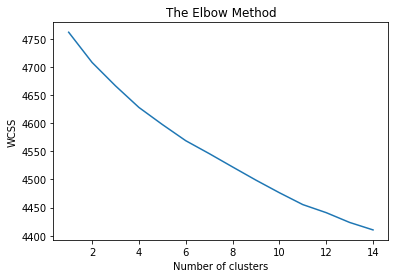

In [28]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0,n_jobs=-1)
    kmeans.fit(reviews)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
#12 clusters
kmeans = KMeans(n_clusters = 12, n_init = 20, n_jobs = -1) 
kmeans.fit(reviews)
# We look at 6 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : kindl, love, read, upgrad, great, best, better, screen, replac, bought, easi, second, model, like, year, light, veri, size, purchas, use, origin, version, tablet, want, price
1 : book, read, kindl, love, great, easi, light, game, tablet, reader, size, just, download, need, like, screen, purchas, perfect, want, devic, carri, watch, bought, use, onli
2 : tablet, love, bought, like, app, amazon, work, doe, screen, need, purchas, time, just, price, perfect, use, realli, want, better, onli, product, recommend, easi, best, child
3 : great, work, tablet, price, product, love, recommend, easi, sound, littl, bought, best, just, need, friend, purchas, color, like, featur, app, nice, speaker, awesom, valu, movi
4 : echo, plus, love, great, amazon, sound, video, music, home, like, work, alexa, devic, product, screen, better, light, smart, featur, bulb, hous, famili, easi, addit, purchas
5 : good, tablet, price, veri, product, work, great, qualiti, easi, sound, pretti, read, nice, love, recomme

In [30]:
#10 clusters
kmeans = KMeans(n_clusters = 10, n_init = 20, n_jobs = -1) 
kmeans.fit(reviews)
# We look at 6 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : kindl, good, screen, like, easi, love, better, use, devic, bought, amazon, just, purchas, work, product, time, doe, realli, enjoy, want, need, best, price, sound, onli
1 : great, work, product, price, easi, recommend, love, sound, tablet, good, life, batteri, friend, like, home, app, speaker, purchas, best, camera, bought, just, need, awesom, valu
2 : kid, great, tablet, love, easi, app, good, game, price, bought, amazon, play, littl, parent, awesom, like, recommend, entertain, free, adult, time, learn, kindl, control, grandson
3 : veri, easi, product, happi, good, tablet, love, great, purchas, kindl, price, nice, help, pleas, bought, durabl, satisfi, work, best, grandson, qualiti, recommend, time, learn, child
4 : gift, love, christma, bought, purchas, great, price, wife, perfect, absolut, tablet, easi, kindl, gave, year, good, birthday, veri, product, mother, enjoy, work, game, like, famili
5 : tablet, great, price, good, app, love, need, game, amazon, perfect, play, child, year,

In [ ]:
tpoic modelling

In [31]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(reviews)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, tvec3, number_words)

Topics found via LDA:

Topic #0:
tablet doe time good batteri amazon read kid limit everyth

Topic #1:
kindl better wife great love replac sound smart echo home

Topic #2:
music great play video question amazon work internet echo answer

Topic #3:
echo great featur sound work screen camera expect like alexa

Topic #4:
tablet love great kid recommend game year easi bought friend

Topic #5:
veri great product easi good tablet purchas love happi price

Topic #6:
love alexa echo bought christma gift light famili music hous

Topic #7:
easi need tablet great love easier doe good amazon veri

Topic #8:
read book kindl love tablet perfect great light watch size

Topic #9:
tablet veri great fast love easi bought kindl function conveni
